In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('white')

In [2]:
year = 2019
ticker = 'IFM'
string = str(year)+'/'+ticker+'.csv'
col_names=['TIME', 'X', 'Y', 'Z'] 

df = pd.read_csv(os.path.join('E:\CTA quant/ml_cta-master/data/index/',string), index_col=0, encoding='gbk')
df.columns = ['code', 'time', 'open', 'high', 'low', 'close', 'volume', 'turnover', 'open interest']

df.rename_axis("type", axis='index', inplace=True)
df['time'] = pd.to_datetime(df['time'])

df.reset_index(inplace=True)

#df = df.iloc[0:100, :]
#df.head(1000)


In [3]:
df['day'] = df['time'].map(lambda x: x.year)*10000 + df['time'].map(lambda x: x.month)*100 + df['time'].map(lambda x: x.day)

Here we first group data by a time window n, and calculate each factor based on the data grouped together.

In [105]:
n = 240 # the time interval to partition the price series into
def func(i):
    return (i - i%n)

df['ind'] = df.index
df['ind'] = df.ind.apply(func)

In the following df1 records factors calculated from the grouped dataset, including "RVar", "RSkew", "RKurtosis", 'Downward', 'Pearsoncorr', 'TrendStrength'. In addition, we also label each time window by 1 if the close price at the end of the time window is larger than the open price at the start of the time window, and 0 otherwise.

In [106]:
df['return_min'] = (df['close'])/(df['open'])
df['return_min'] = np.log(df['return_min'])
#df['return'] = (df['close']-df['open'].shift(periods = n-1))/(df['open'].shift(periods = m-1))
df1 = df.copy()
df1 = df.groupby(df.ind)
thres_up = 0.00
thres_down= 0.00


def Get_indices(x):
    var = sum(x.return_min * x.return_min)
    #print(var)
    skew = math.sqrt(n) * sum(x.return_min * x.return_min * x.return_min * x.return_min)/(var**(3/2))
    kurt = n * sum(np.power(x.return_min,4)) / (np.power(var,2))
    
    # xia xing bo dong yin zi
    T = x.where(x.return_min < 0, 0).return_min
    down = sum(T * x.return_min) / (var)
    
    # jia liang xiang guan xing
    p = x.volume.corr(x.open)
    
    # dong liang lei
    trendstr = sum(x.close - x.open)/ sum(np.abs(x.close - x.open))
    
    # flow in ratio
#     K = 
#     fir = x.volume * x.close * ((x.close - x.open)/abs(x.close - x.open)) / K
    
    
    # day
    day = int(x.day.mean())
    
    # characterizing stock
    if sum(x.close - x.open) > 0:
        #if max(x.close)-x.open.loc[0] > thres_up * x.open.loc[0] and -min(x.close)+x.open.loc[0] < thres_down * x.open.loc[0]:
        label = 1
#         else:
#             label = 0
    else:
#         if max(x.close)-x.open.loc[0] < thres_up * x.open.loc[0] and -min(x.close)+x.open.loc[0] > thres_down * x.open.loc[0]:
        label = 0
#         else:
#             label = 0
    
    # return during the hold period
    ret = np.log(sum(x.close - x.open)/x.open.loc[0] + 1)
    
    return pd.Series([var, skew, kurt, down, p, trendstr, day, label, ret], index=["RVar", "RSkew", "RKurtosis", 'Downward', 'Pearsoncorr', 'TrendStrength', 'Day', 'Label', 'Logreturn'])

df1 = df1.apply(Get_indices)
df1

,RVar,RSkew,RKurtosis,Downward,Pearsoncorr,TrendStrength,Day,Label,Logreturn
ind,,,,,,,,,
0,0.000111,0.004379,6.453061,0.570997,0.488625,-0.119954,20190102.0,0.0,-0.013906
240,0.000150,0.003786,4.782090,0.451817,0.447389,0.015253,20190103.0,1.0,0.002161
480,0.000219,0.007842,8.202265,0.340750,-0.400557,0.201958,20190104.0,1.0,0.033028
720,0.000127,0.003471,4.772394,0.520225,0.049290,0.016260,20190107.0,1.0,0.002095
960,0.000047,0.003215,7.251933,0.479695,-0.128439,0.027972,20190108.0,1.0,0.002098
...,...,...,...,...,...,...,...,...,...
57360,0.000032,0.001169,3.214703,0.480875,-0.177749,0.017844,20191225.0,1.0,0.001250
57600,0.000055,0.001909,3.990002,0.469480,0.145771,0.076043,20191226.0,1.0,0.006620
57840,0.000088,0.001629,2.693423,0.527654,0.018494,-0.012987,20191227.0,0.0,-0.001536


In [107]:
df1.isna().sum()

RVar             0
RSkew            0
RKurtosis        0
Downward         0
Pearsoncorr      0
TrendStrength    0
Day              0
Label            0
Logreturn        0
dtype: int64

In [108]:
# for str in df1.columns.unique():
#     df1[str] = df1[str].rolling()
window_size = 20
# df2 = df1.rolling(window_size, 1).mean()
l = ["RVar", "RSkew", "RKurtosis", 'Downward', 'Pearsoncorr', 'TrendStrength']
for str in l:
    df1[str] = df1[str].rolling(window_size, 1).mean()


In [109]:
df1['Label'] = df1['Label'].shift(-1)
df1['Logreturn'] = df1['Logreturn'].shift(-1)
df1 = df1.dropna()

In [110]:
# from scipy import stats
# df1 = df1.dropna()
# z_scores = stats.zscore(df1.loc[:,l])
# # calculate z-scores of `df`

# abs_z_scores = np.abs(z_scores)
# filtered_entries = (abs_z_scores < 3).all(axis=1)
# new_df = df1[filtered_entries]
# df1 = new_df

In [111]:
df1.shape

(243, 9)

The following is a pairplot of factors. 'Downward', 'Pearsoncorr', 'TrendStrength' follow a nice bell-shape symmetric distribution, while the first three do not.

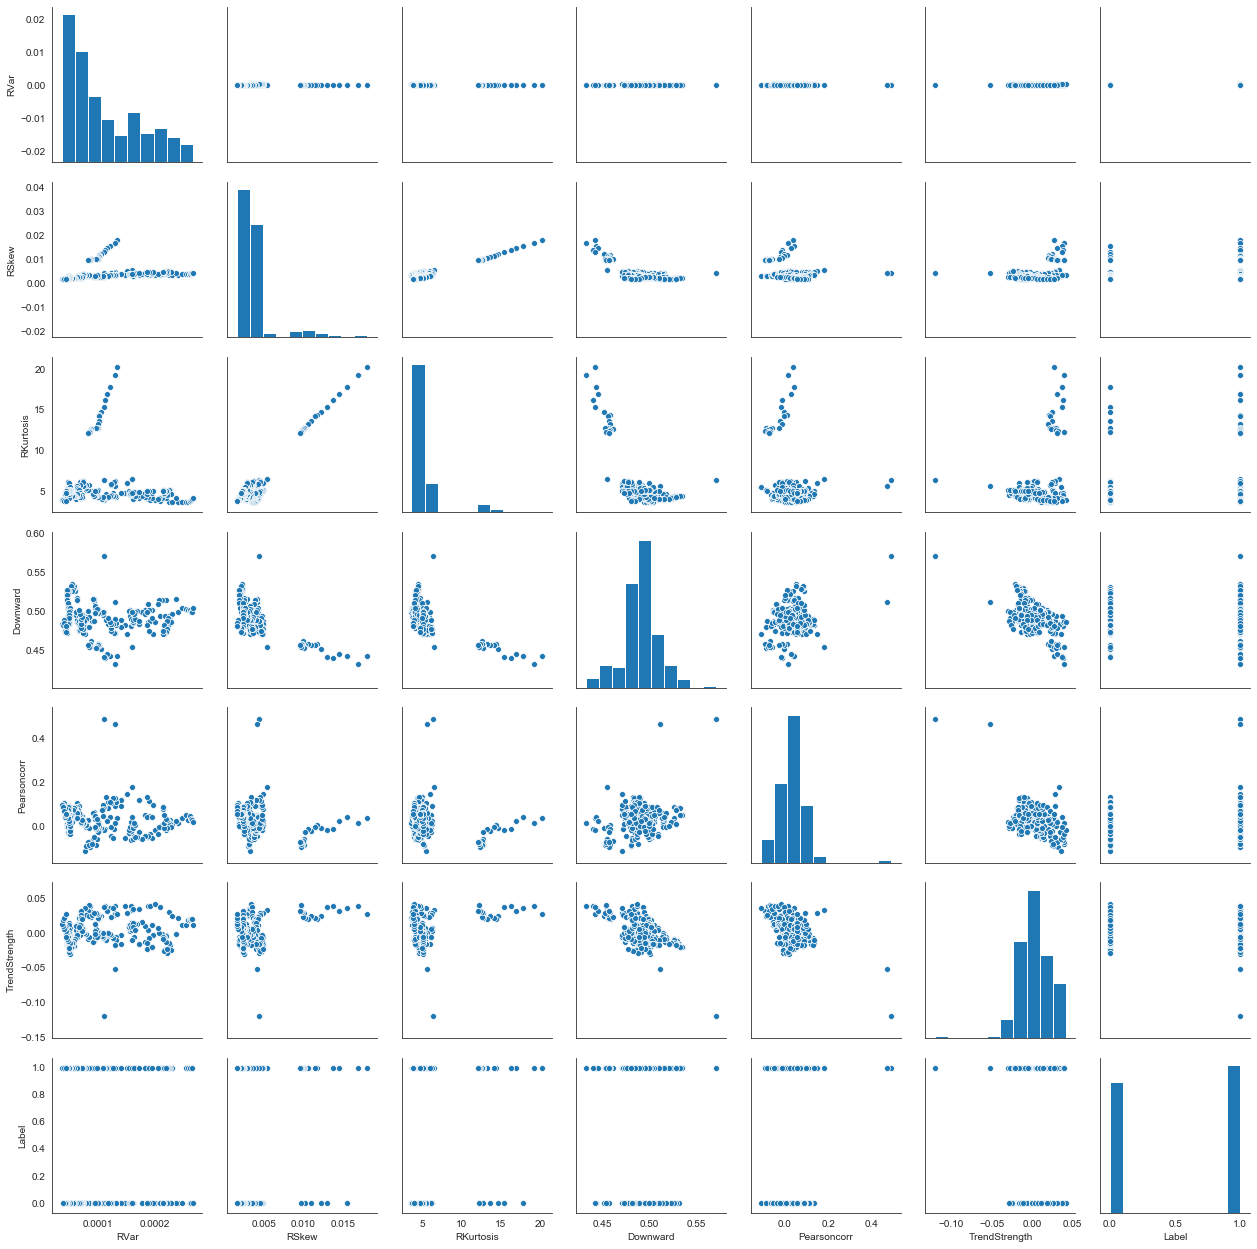

In [112]:
cols = ["RVar", "RSkew", "RKurtosis", 'Downward', 'Pearsoncorr', 'TrendStrength', 'Label']
sns.pairplot(df1[cols], size = 2.5)

Correlation between factors and label. Correlation between RSkew, RKurtosis is quite high, this is not good for interpreting linear regression coefficient. Label is not significantly correlated with anybody.

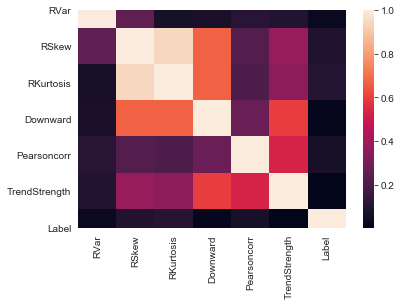

In [113]:
# correlation map
n =len(cols)
k = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        k[i,j] = abs(df1.loc[:,cols[i]].corr(df1.loc[:,cols[j]]))
k = pd.DataFrame(k, columns = cols, index= cols)
sns.heatmap(k)

As predicted, there exists multicollinearity between RSkew, RKurtosis as calculated by variance inflation factor below.

In [114]:
# check for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

calc_vif(df1.iloc[:,1:-3])

,variables,VIF
0,RSkew,29.788793
1,RKurtosis,46.594032
2,Downward,7.036888
3,Pearsoncorr,1.741104
4,TrendStrength,1.588451


The following is a logistic regression whose target are the labels. Notice how Pseudo R-squ is low, and how Log-Likelihood and  LL-Null are very close. These all indicate that the constructed factors lack explanatory power of the information carried by the labels. Either we seek more informative factors, or think about other ways to define labels.


In [115]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
l = ['RSkew', "RKurtosis", 'Downward', 'Pearsoncorr', 'TrendStrength']
Xtrain = df1[l] 
ytrain = df1[['Label']] 
model = sm.Logit(ytrain, Xtrain).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.681899
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                  243
Model:                          Logit   Df Residuals:                      238
Method:                           MLE   Df Model:                            4
Date:                Fri, 12 Mar 2021   Pseudo R-squ.:                 0.01351
Time:                        12:37:47   Log-Likelihood:                -165.70
converged:                       True   LL-Null:                       -167.97
Covariance Type:            nonrobust   LLR p-value:                    0.3378
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
RSkew           -18.8977    151.735     -0.125      0.901    -316.294     278.498
RKurtosis         0.